In [149]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8-whitegrid")
import levenberg_marquardt
from matplotlib.pyplot import figure
import sabr
from importlib import reload
reload(sabr)
from sabr import calibrate_sabr
import datetime
import warnings
warnings.filterwarnings("ignore")
from scipy import stats as sps
from typing import Union
import h5py
import matplotlib.dates as mdates
from tqdm.notebook import tqdm

In [7]:
# heavy
# %%time
raw = pd.HDFStore('../datasets/eth-20230224.h5','r').get("/eth")
# raw2 = pd.HDFStore('../datasets/eth-20230127.h5','r').get("/eth")
# raw3 = pd.HDFStore('../datasets/eth-20230310.h5','r').get("/eth")
# raw = pd.concat([raw1, raw2, raw3]).drop_duplicates()

<AxesSubplot: >

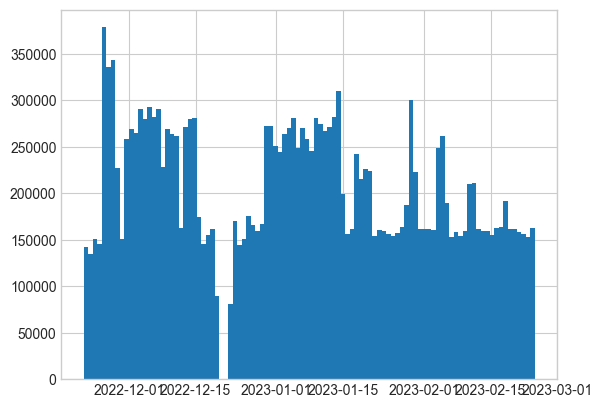

In [8]:
raw.dt.hist(bins = 100)

In [118]:
def process_data(data):
    # only options
    df = data.copy()
    df = df[(df["instrument"].str.endswith("C")) | (df["instrument"].str.endswith("P"))].sort_values("dt")
    df["type"] = np.where(df["instrument"].str.endswith("C"), "call", "put")
    
    perpetuals = data[data["instrument"].str.endswith("PERPETUAL")][["dt", "price"]].copy()
    perpetuals = perpetuals.rename(columns = {"price": "underlying_price"}).sort_values("dt")
    
    def get_strike(x):
        return int(x.split("-")[2])
    
    def get_expiration(x):
        return x.split("-")[1]
    

    df["strike_price"] = df["instrument"].apply(get_strike)
    df["expiration"] = df["instrument"].apply(get_expiration)
    
    def unix_time_millis(dt):
        epoch = datetime.datetime.utcfromtimestamp(0)
        return int((dt - epoch).total_seconds() * 1000_000)
    
    def get_normal_date(s):
        """Function to convert date to find years to maturity"""
        monthToNum = {
            "JAN": 1,
            "FEB": 2,
            "MAR": 3,
            "APR": 4,
            "MAY": 5,
            "JUN": 6,
            "JUL": 7,
            "AUG": 8,
            "SEP": 9,
            "OCT": 10,
            "NOV": 11,
            "DEC": 12,
        }

        full_date = s.split("-")[1]
        try:
            day = int(full_date[:2])
            month = monthToNum[full_date[2:5]]
        except:
            day = int(full_date[:1])
            month = monthToNum[full_date[1:4]]
        
        year = int("20" + full_date[-2:])
        exp_date = datetime.datetime(year, month, day)
        return unix_time_millis(exp_date)
    
    df["dt"] = pd.to_datetime(df["dt"])
    perpetuals["dt"] = pd.to_datetime(perpetuals["dt"])
    
    df = pd.merge_asof(df, perpetuals, on="dt",
                       tolerance=pd.Timedelta('7 minutes'),
                       direction='nearest',)
    
    df["timestamp"] = df["dt"].apply(unix_time_millis)
    df["expiration"] = df["instrument"].apply(get_normal_date)
    df = df.rename(columns = {"price": "mark_price"})
    
    
    return df


In [10]:
%%time
start = process_data(raw)


CPU times: user 50.2 s, sys: 19.3 s, total: 1min 9s
Wall time: 1min 22s


In [11]:
df = start.copy()
# df = df[(df["timestamp"]>=1672000000000000) & (df["timestamp"]<=1672800000000000)]
df

,dt,mark_price,instrument,type,strike_price,expiration,underlying_price,timestamp
0,2022-11-21 13:08:24.511,0.0005,ETH-25NOV22-1700-C,call,1700,1669334400000000,1133.90,1669036104511000
1,2022-11-21 13:08:24.511,0.0005,ETH-25NOV22-2400-C,call,2400,1669334400000000,1133.90,1669036104511000
2,2022-11-21 13:08:24.511,0.0020,ETH-25NOV22-700-P,put,700,1669334400000000,1133.90,1669036104511000
3,2022-11-21 13:08:24.511,0.0005,ETH-25NOV22-3800-C,call,3800,1669334400000000,1133.90,1669036104511000
4,2022-11-21 13:08:24.511,0.0005,ETH-25NOV22-3400-C,call,3400,1669334400000000,1133.90,1669036104511000
...,...,...,...,...,...,...,...,...
7498621,2023-02-24 07:13:46.716,0.0300,ETH-24FEB23-1700-P,put,1700,1677196800000000,1651.85,1677222826716000
7498622,2023-02-24 07:13:47.576,0.2975,ETH-24FEB23-1200-C,call,1200,1677196800000000,1651.85,1677222827576000
7498623,2023-02-24 07:13:51.208,0.0015,ETH-24FEB23-1650-P,put,1650,1677196800000000,1651.85,1677222831208000
7498624,2023-02-24 07:13:55.748,0.2980,ETH-24FEB23-1200-C,call,1200,1677196800000000,1651.85,1677222835748000


# See params dynamic

In [156]:
%%time
# calibrate base
number_of_dots = 2000
timestamps_hm = []

params_all = []
params_beta = []

errors_all = []
errors_beta = []

alpha = np.float64(1.0)  # 
v = np.float64(1.3)  # 
beta = np.float64(0.5)  # 
rho = np.float64(-0.1)  # 

start_params = np.array([alpha, v, beta, rho])

# Get ticks with similar distnce from available data
calibr_borders = df[(df["dt"] >= "2023-02-04") & (df["dt"] <= "2023-02-04 23:00:00")].copy()
df_only_exp = calibr_borders[calibr_borders["expiration"] == calibr_borders.sample(1).expiration.iloc[0]].copy()

print("Optimize first params with random start once")
calibrated_params_all, first_error_all, _ = calibrate_sabr(df = df_only_exp, 
                                                        start_params = start_params, 
                                                        calibration_type = "all")
calibrated_params_beta, first_error_beta, _ = calibrate_sabr(df = df_only_exp, 
                                                        start_params = start_params, 
                                                        calibration_type = "beta")


print("All first calibrated:", [round(x, 3) for x in calibrated_params_all], "error:", first_error_all)
print("Beta first calibrated:", [round(x, 3) for x in calibrated_params_beta], "error:", first_error_beta)


timestamps = np.linspace(calibr_borders.timestamp.min(), calibr_borders.timestamp.max(), number_of_dots)
for timestamp in tqdm(timestamps):
    try:
        # zero params for each point are params from last step
        calibrated_params_all, error_all, _ = calibrate_sabr(df = df_only_exp, start_params = calibrated_params_all, 
                                    timestamp = timestamp, calibration_type = "all")
        print("All calibrated:", [round(x, 3) for x in calibrated_params_all], 
              "error:", error_all)
                
        calibrated_params_beta, error_beta, _ = calibrate_sabr(df = df_only_exp, start_params = calibrated_params_beta, 
                                    timestamp = timestamp, calibration_type = "beta")
        print("nu0 calibrated:", [round(x, 3) for x in calibrated_params_beta], 
              "error:", error_beta)
        
        params_all.append(calibrated_params_all)
        errors_all.append(error_all)
        params_beta.append(calibrated_params_beta)
        errors_beta.append(error_beta)
        timestamps_hm.append(timestamp)
        
        print("    ")
        # save timestame that could calibrate
    except:
        continue

    
timestamps_hm = [datetime.datetime.fromtimestamp(x/1000000.0) for x in timestamps_hm]
params_all = np.array(params_all).T
params_beta = np.array(params_beta).T





Optimize first params with random start once
All first calibrated: [3.069, 8.11, 0.882, -0.025] error: 0.011169081076948585
Beta first calibrated: [0.542, 7.979, 1.0, -0.068] error: 0.011147489051646654


  0%|          | 0/2000 [00:00<?, ?it/s]

All calibrated: [1.669, 6.919, 0.928, -0.058] error: 0.00936646244450239
nu0 calibrated: [0.577, 6.856, 1.0, -0.084] error: 0.0093618798645725
    
All calibrated: [1.668, 6.917, 0.928, -0.059] error: 0.009246814067624455
nu0 calibrated: [0.573, 6.884, 1.0, -0.086] error: 0.009253277902483318
    
All calibrated: [1.665, 6.911, 0.927, -0.051] error: 0.009647802839499483
nu0 calibrated: [0.573, 6.851, 1.0, -0.075] error: 0.009661504672702615
    
All calibrated: [1.667, 6.899, 0.927, -0.051] error: 0.00964146683074005
nu0 calibrated: [0.576, 6.83, 1.0, -0.077] error: 0.009648995684059575
    
All calibrated: [1.667, 6.898, 0.927, -0.051] error: 0.009612188580582125
nu0 calibrated: [0.574, 6.844, 1.0, -0.077] error: 0.00963163147865302
    
All calibrated: [1.665, 6.908, 0.927, -0.043] error: 0.009487783038453127
nu0 calibrated: [0.572, 6.86, 1.0, -0.067] error: 0.009502811828171639
    
All calibrated: [1.665, 6.908, 0.927, -0.043] error: 0.009501279354659959
nu0 calibrated: [0.572, 6.8

All calibrated: [0.576, 6.701, 1.0, -0.038] error: 0.009533393884841836
nu0 calibrated: [0.576, 6.701, 1.0, -0.038] error: 0.009533393850442365
    
All calibrated: [0.576, 6.701, 1.0, -0.038] error: 0.009533393861204519
All calibrated: [0.576, 6.701, 1.0, -0.038] error: 0.009533393854811348
All calibrated: [0.576, 6.701, 1.0, -0.038] error: 0.00953339385262953
All calibrated: [0.576, 6.701, 1.0, -0.038] error: 0.009533393852341691
All calibrated: [0.576, 6.701, 1.0, -0.038] error: 0.00953339385167494
All calibrated: [0.575, 6.719, 1.0, -0.045] error: 0.009545021589409912
nu0 calibrated: [0.575, 6.719, 1.0, -0.045] error: 0.00954502157590597
    
All calibrated: [0.575, 6.716, 1.0, -0.047] error: 0.009640320418959814
nu0 calibrated: [0.575, 6.716, 1.0, -0.047] error: 0.009640320324425323
    
All calibrated: [0.578, 6.687, 1.0, -0.044] error: 0.009798480471770487
nu0 calibrated: [0.578, 6.687, 1.0, -0.044] error: 0.009798480023810098
    
All calibrated: [0.578, 6.687, 1.0, -0.044] err

All calibrated: [0.586, 6.659, 1.0, -0.049] error: 0.009729113574342568
nu0 calibrated: [0.586, 6.659, 1.0, -0.049] error: 0.009729113215895781
    
All calibrated: [0.586, 6.659, 1.0, -0.049] error: 0.009729113328991816
nu0 calibrated: [0.586, 6.659, 1.0, -0.049] error: 0.009729113215895748
    
All calibrated: [0.586, 6.659, 1.0, -0.049] error: 0.00972911326228691
All calibrated: [0.586, 6.659, 1.0, -0.049] error: 0.009729113243294164
All calibrated: [0.586, 6.659, 1.0, -0.049] error: 0.00972911323740817
All calibrated: [0.586, 6.659, 1.0, -0.049] error: 0.009729113236170572
All calibrated: [0.586, 6.663, 1.0, -0.048] error: 0.009746550370847703
nu0 calibrated: [0.586, 6.663, 1.0, -0.048] error: 0.00974655023828289
    
All calibrated: [0.586, 6.661, 1.0, -0.049] error: 0.00975362209392259
nu0 calibrated: [0.586, 6.661, 1.0, -0.049] error: 0.009753620688743983
    
All calibrated: [0.586, 6.661, 1.0, -0.049] error: 0.009753998627808019
nu0 calibrated: [0.586, 6.661, 1.0, -0.049] erro

All calibrated: [0.577, 6.746, 1.0, -0.043] error: 0.009979595525925785
nu0 calibrated: [0.578, 6.746, 1.0, -0.043] error: 0.00997959495004585
    
All calibrated: [0.577, 6.746, 1.0, -0.043] error: 0.009979595014997213
All calibrated: [0.578, 6.746, 1.0, -0.043] error: 0.009979594967892266
All calibrated: [0.578, 6.746, 1.0, -0.043] error: 0.009979594957718127
All calibrated: [0.579, 6.753, 1.0, -0.044] error: 0.009686397644145878
nu0 calibrated: [0.579, 6.753, 1.0, -0.044] error: 0.009686396734314047
    
All calibrated: [0.579, 6.751, 1.0, -0.044] error: 0.00970623393421888
nu0 calibrated: [0.579, 6.751, 1.0, -0.044] error: 0.009706233363562662
    
All calibrated: [0.579, 6.753, 1.0, -0.044] error: 0.009693356562610984
nu0 calibrated: [0.579, 6.753, 1.0, -0.044] error: 0.009693356537588156
    
All calibrated: [0.579, 6.75, 1.0, -0.044] error: 0.009707463671476745
nu0 calibrated: [0.579, 6.75, 1.0, -0.044] error: 0.009707462717922027
    
All calibrated: [0.579, 6.75, 1.0, -0.044] 

All calibrated: [0.582, 6.73, 1.0, -0.051] error: 0.01042719839712385
All calibrated: [0.582, 6.73, 1.0, -0.051] error: 0.01042719822833662
All calibrated: [0.582, 6.73, 1.0, -0.051] error: 0.01042719819343011
All calibrated: [0.582, 6.73, 1.0, -0.051] error: 0.010427198183229888
All calibrated: [0.583, 6.738, 1.0, -0.057] error: 0.01043015338367804
nu0 calibrated: [0.583, 6.738, 1.0, -0.057] error: 0.01043015320529241
    
All calibrated: [0.583, 6.738, 1.0, -0.057] error: 0.010430125774942742
nu0 calibrated: [0.583, 6.738, 1.0, -0.057] error: 0.010430125621240871
    
All calibrated: [0.586, 6.705, 1.0, -0.057] error: 0.01061434243800316
nu0 calibrated: [0.586, 6.705, 1.0, -0.057] error: 0.010614334343257663
    
All calibrated: [0.585, 6.718, 1.0, -0.058] error: 0.010537459631978247
nu0 calibrated: [0.585, 6.718, 1.0, -0.058] error: 0.010537459558173343
    
All calibrated: [0.585, 6.718, 1.0, -0.058] error: 0.01053745959863887
nu0 calibrated: [0.585, 6.718, 1.0, -0.058] error: 0.01

All calibrated: [0.58, 6.786, 1.0, -0.051] error: 0.01039848366531768
All calibrated: [0.58, 6.786, 1.0, -0.051] error: 0.01039848365653821
All calibrated: [0.58, 6.786, 1.0, -0.051] error: 0.010398483654885913
All calibrated: [0.582, 6.769, 1.0, -0.052] error: 0.010526193829202184
nu0 calibrated: [0.582, 6.769, 1.0, -0.052] error: 0.010526191650800128
    
All calibrated: [0.58, 6.784, 1.0, -0.051] error: 0.010457639434369625
nu0 calibrated: [0.58, 6.784, 1.0, -0.051] error: 0.010457637369298202
    
All calibrated: [0.58, 6.784, 1.0, -0.051] error: 0.010457392873812666
nu0 calibrated: [0.58, 6.784, 1.0, -0.051] error: 0.010457392329854443
    
All calibrated: [0.58, 6.784, 1.0, -0.051] error: 0.010457392482579514
All calibrated: [0.58, 6.784, 1.0, -0.051] error: 0.010457392377276187
All calibrated: [0.58, 6.784, 1.0, -0.051] error: 0.010457392347832295
All calibrated: [0.58, 6.791, 1.0, -0.05] error: 0.010358027881747315
nu0 calibrated: [0.58, 6.791, 1.0, -0.05] error: 0.010358027802

All calibrated: [0.579, 6.859, 1.0, -0.045] error: 0.009563204786172206
nu0 calibrated: [0.579, 6.859, 1.0, -0.045] error: 0.009563203221220194
    
All calibrated: [0.579, 6.859, 1.0, -0.045] error: 0.009563203380636322
All calibrated: [0.579, 6.859, 1.0, -0.045] error: 0.009563203259436957
All calibrated: [0.579, 6.859, 1.0, -0.045] error: 0.009563203235755284
All calibrated: [0.579, 6.859, 1.0, -0.045] error: 0.00956320322866984
All calibrated: [0.584, 6.812, 1.0, -0.038] error: 0.00952917694245761
nu0 calibrated: [0.584, 6.812, 1.0, -0.038] error: 0.009529167547652977
    
All calibrated: [0.579, 6.857, 1.0, -0.036] error: 0.009374137783442841
nu0 calibrated: [0.579, 6.857, 1.0, -0.036] error: 0.00937413758223685
    
All calibrated: [0.579, 6.859, 1.0, -0.036] error: 0.009367322964133278
nu0 calibrated: [0.579, 6.859, 1.0, -0.036] error: 0.009367322943528987
    
All calibrated: [0.579, 6.859, 1.0, -0.036] error: 0.00936732296367087
All calibrated: [0.579, 6.859, 1.0, -0.036] erro

All calibrated: [0.568, 6.981, 1.0, -0.053] error: 0.009730977626268792
nu0 calibrated: [0.568, 6.981, 1.0, -0.053] error: 0.009730975827230077
    
All calibrated: [0.569, 6.978, 1.0, -0.053] error: 0.009731018130788433
nu0 calibrated: [0.569, 6.978, 1.0, -0.053] error: 0.009731016332575533
    
All calibrated: [0.569, 6.978, 1.0, -0.053] error: 0.009731016613271392
All calibrated: [0.569, 6.978, 1.0, -0.053] error: 0.009731016468369274
All calibrated: [0.569, 6.978, 1.0, -0.053] error: 0.009731016375193611
All calibrated: [0.569, 6.978, 1.0, -0.053] error: 0.00973101634896772
All calibrated: [0.565, 6.976, 1.0, -0.061] error: 0.010632302867995429
nu0 calibrated: [0.565, 6.976, 1.0, -0.061] error: 0.010632302844700013
    
All calibrated: [0.567, 6.955, 1.0, -0.061] error: 0.01076732212507036
nu0 calibrated: [0.567, 6.955, 1.0, -0.061] error: 0.010767319888442902
    
All calibrated: [0.567, 6.956, 1.0, -0.061] error: 0.010778219544677317
nu0 calibrated: [0.567, 6.956, 1.0, -0.061] er

All calibrated: [0.574, 6.944, 1.0, -0.054] error: 0.01066143993378209
nu0 calibrated: [0.574, 6.944, 1.0, -0.054] error: 0.010661439897314653
    
All calibrated: [0.574, 6.944, 1.0, -0.054] error: 0.010661439928686723
All calibrated: [0.574, 6.944, 1.0, -0.054] error: 0.010661439927490067
All calibrated: [0.574, 6.944, 1.0, -0.054] error: 0.010661439926948017
All calibrated: [0.574, 6.944, 1.0, -0.054] error: 0.010661439926700711
All calibrated: [0.577, 6.923, 1.0, -0.056] error: 0.010563799449537125
nu0 calibrated: [0.577, 6.923, 1.0, -0.056] error: 0.010563794515902381
    
All calibrated: [0.574, 6.954, 1.0, -0.055] error: 0.010411350317334178
nu0 calibrated: [0.574, 6.954, 1.0, -0.055] error: 0.010411349966503282
    
All calibrated: [0.574, 6.953, 1.0, -0.055] error: 0.010414448898324947
nu0 calibrated: [0.574, 6.953, 1.0, -0.055] error: 0.010414448558886477
    
All calibrated: [0.574, 6.953, 1.0, -0.055] error: 0.010414448655939563
All calibrated: [0.574, 6.953, 1.0, -0.055] e

All calibrated: [0.547, 7.208, 1.0, -0.058] error: 0.00994509099960813
All calibrated: [0.547, 7.208, 1.0, -0.058] error: 0.009945090998502012
All calibrated: [0.547, 7.208, 1.0, -0.058] error: 0.009945090997983831
All calibrated: [0.548, 7.209, 1.0, -0.058] error: 0.009952450735336562
nu0 calibrated: [0.548, 7.209, 1.0, -0.058] error: 0.009952448947999482
    
All calibrated: [0.548, 7.208, 1.0, -0.058] error: 0.00993545393978703
nu0 calibrated: [0.548, 7.208, 1.0, -0.058] error: 0.009935453490883971
    
All calibrated: [0.549, 7.198, 1.0, -0.058] error: 0.00997783286142263
nu0 calibrated: [0.549, 7.198, 1.0, -0.058] error: 0.00997783122880559
    
All calibrated: [0.549, 7.198, 1.0, -0.058] error: 0.009977831461409058
All calibrated: [0.549, 7.198, 1.0, -0.058] error: 0.00997783135186192
All calibrated: [0.549, 7.198, 1.0, -0.058] error: 0.009977831267425087
All calibrated: [0.549, 7.198, 1.0, -0.058] error: 0.009977831243655984
All calibrated: [0.548, 7.207, 1.0, -0.052] error: 0.0

nu0 calibrated: [0.548, 7.245, 1.0, -0.058] error: 0.009908696178209272
    
All calibrated: [0.548, 7.245, 1.0, -0.058] error: 0.00990869633499076
All calibrated: [0.548, 7.245, 1.0, -0.058] error: 0.009908696241863838
All calibrated: [0.545, 7.274, 1.0, -0.066] error: 0.010020359955778739
nu0 calibrated: [0.545, 7.274, 1.0, -0.066] error: 0.01002035987095354
    
All calibrated: [0.544, 7.282, 1.0, -0.064] error: 0.009920068651507
nu0 calibrated: [0.544, 7.282, 1.0, -0.064] error: 0.009920068619668555
    
All calibrated: [0.544, 7.282, 1.0, -0.064] error: 0.009919335737451969
nu0 calibrated: [0.544, 7.282, 1.0, -0.064] error: 0.00991933524557329
    
All calibrated: [0.544, 7.282, 1.0, -0.064] error: 0.009919319703277415
nu0 calibrated: [0.544, 7.282, 1.0, -0.064] error: 0.009919319565467316
    
All calibrated: [0.544, 7.282, 1.0, -0.064] error: 0.009919319608215967
All calibrated: [0.544, 7.282, 1.0, -0.064] error: 0.00991931958165607
All calibrated: [0.544, 7.282, 1.0, -0.064] er

All calibrated: [0.548, 7.259, 1.0, -0.063] error: 0.010984345068398703
nu0 calibrated: [0.548, 7.259, 1.0, -0.063] error: 0.010984344013931373
    
All calibrated: [0.548, 7.259, 1.0, -0.063] error: 0.010984344129451653
All calibrated: [0.548, 7.259, 1.0, -0.063] error: 0.010984344042983638
All calibrated: [0.548, 7.259, 1.0, -0.063] error: 0.01098434402566122
All calibrated: [0.548, 7.259, 1.0, -0.063] error: 0.010984344020253296
All calibrated: [0.548, 7.263, 1.0, -0.065] error: 0.010992541059683303
nu0 calibrated: [0.548, 7.262, 1.0, -0.065] error: 0.010992540950047303
    
All calibrated: [0.548, 7.262, 1.0, -0.065] error: 0.010992316319430533
nu0 calibrated: [0.548, 7.262, 1.0, -0.065] error: 0.010992316023362569
    
All calibrated: [0.548, 7.262, 1.0, -0.065] error: 0.010992950468905869
nu0 calibrated: [0.548, 7.262, 1.0, -0.065] error: 0.010992950172558687
    
All calibrated: [0.548, 7.262, 1.0, -0.065] error: 0.010992950259281289
All calibrated: [0.548, 7.262, 1.0, -0.065] e

All calibrated: [0.545, 7.335, 1.0, -0.061] error: 0.010857578575420565
All calibrated: [0.545, 7.335, 1.0, -0.061] error: 0.010857578574549331
All calibrated: [0.545, 7.333, 1.0, -0.062] error: 0.010856339926498032
nu0 calibrated: [0.545, 7.333, 1.0, -0.062] error: 0.0108563390258556
    
All calibrated: [0.545, 7.333, 1.0, -0.063] error: 0.010869715243692046
nu0 calibrated: [0.545, 7.333, 1.0, -0.063] error: 0.01086971521813886
    
All calibrated: [0.546, 7.329, 1.0, -0.063] error: 0.010874545310766297
nu0 calibrated: [0.546, 7.329, 1.0, -0.063] error: 0.010874544272182807
    
All calibrated: [0.546, 7.329, 1.0, -0.063] error: 0.010874544389977451
All calibrated: [0.546, 7.329, 1.0, -0.063] error: 0.010874544300885261
All calibrated: [0.546, 7.329, 1.0, -0.063] error: 0.010874544283766054
All calibrated: [0.546, 7.329, 1.0, -0.063] error: 0.010874544278423305
All calibrated: [0.546, 7.329, 1.0, -0.063] error: 0.010874544277217648
All calibrated: [0.546, 7.329, 1.0, -0.063] error: 0

All calibrated: [0.539, 7.442, 1.0, -0.067] error: 0.010592479178373814
nu0 calibrated: [0.539, 7.442, 1.0, -0.067] error: 0.010592478316934021
    
All calibrated: [0.538, 7.444, 1.0, -0.067] error: 0.010594285965376501
nu0 calibrated: [0.538, 7.444, 1.0, -0.067] error: 0.010594285937636404
    
All calibrated: [0.538, 7.447, 1.0, -0.066] error: 0.010579793523706079
nu0 calibrated: [0.538, 7.447, 1.0, -0.066] error: 0.010579793488704864
    
All calibrated: [0.538, 7.447, 1.0, -0.066] error: 0.010579793519953093
All calibrated: [0.538, 7.447, 1.0, -0.066] error: 0.01057979351915866
All calibrated: [0.538, 7.447, 1.0, -0.066] error: 0.01057979351877871
All calibrated: [0.541, 7.425, 1.0, -0.066] error: 0.010701274749872104
nu0 calibrated: [0.541, 7.425, 1.0, -0.066] error: 0.010701271625850991
    
All calibrated: [0.541, 7.425, 1.0, -0.066] error: 0.01070052238135103
nu0 calibrated: [0.541, 7.425, 1.0, -0.066] error: 0.010700522153578007
    
All calibrated: [0.541, 7.425, 1.0, -0.066

All calibrated: [0.537, 7.636, 1.0, -0.101] error: 0.009200996673209571
All calibrated: [0.537, 7.636, 1.0, -0.101] error: 0.00920099667312958
All calibrated: [0.537, 7.636, 1.0, -0.101] error: 0.009200996672753125
All calibrated: [0.537, 7.636, 1.0, -0.101] error: 0.00920099667260949
All calibrated: [0.537, 7.636, 1.0, -0.101] error: 0.009200996672511973
All calibrated: [0.537, 7.636, 1.0, -0.101] error: 0.009200996672443937
All calibrated: [0.537, 7.636, 1.0, -0.101] error: 0.009200996672396277
All calibrated: [0.537, 7.636, 1.0, -0.101] error: 0.009200996672333777
All calibrated: [0.537, 7.636, 1.0, -0.101] error: 0.00920099667224052
All calibrated: [0.537, 7.636, 1.0, -0.101] error: 0.00920099667218633
All calibrated: [0.537, 7.636, 1.0, -0.101] error: 0.009200996672144069
All calibrated: [0.567, 7.602, 0.997, -0.1] error: 0.009529766197633724
nu0 calibrated: [0.544, 7.6, 1.0, -0.101] error: 0.009530463734171461
    
All calibrated: [0.587, 7.59, 0.995, -0.098] error: 0.00967379533

nu0 calibrated: [0.551, 7.58, 1.0, -0.078] error: 0.009464983161232402
    
All calibrated: [0.754, 7.599, 0.978, -0.073] error: 0.009424164283100191
nu0 calibrated: [0.549, 7.601, 1.0, -0.08] error: 0.009433772108016568
    
All calibrated: [0.754, 7.599, 0.978, -0.073] error: 0.00944101914015777
nu0 calibrated: [0.549, 7.6, 1.0, -0.08] error: 0.009450897561194577
    
All calibrated: [0.754, 7.599, 0.978, -0.073] error: 0.009442764456923438
nu0 calibrated: [0.549, 7.602, 1.0, -0.08] error: 0.009452922363021633
    
All calibrated: [0.754, 7.619, 0.978, -0.07] error: 0.009375948275042092
nu0 calibrated: [0.548, 7.615, 1.0, -0.077] error: 0.009387606824982844
    
All calibrated: [0.754, 7.62, 0.978, -0.07] error: 0.0093945339685766
nu0 calibrated: [0.548, 7.613, 1.0, -0.077] error: 0.009405950607190348
    
All calibrated: [0.753, 7.636, 0.978, -0.069] error: 0.009217538508772575
nu0 calibrated: [0.546, 7.636, 1.0, -0.076] error: 0.009230299223249916
    
All calibrated: [0.79, 7.631,

nu0 calibrated: [0.551, 7.585, 1.0, -0.069] error: 0.010895463525285335
    
All calibrated: [1.175, 7.597, 0.949, -0.049] error: 0.010870408741393396
nu0 calibrated: [0.551, 7.585, 1.0, -0.069] error: 0.010890627167149527
    
All calibrated: [1.175, 7.599, 0.949, -0.049] error: 0.01087774748641067
nu0 calibrated: [0.551, 7.585, 1.0, -0.068] error: 0.010898202718118335
    
All calibrated: [1.176, 7.613, 0.949, -0.046] error: 0.010555802717602607
nu0 calibrated: [0.553, 7.583, 1.0, -0.063] error: 0.010586718050843208
    
All calibrated: [1.175, 7.61, 0.949, -0.047] error: 0.01095610133899985
nu0 calibrated: [0.553, 7.571, 1.0, -0.066] error: 0.01097766941736881
    
All calibrated: [1.175, 7.611, 0.949, -0.049] error: 0.010960727098898775
nu0 calibrated: [0.553, 7.567, 1.0, -0.068] error: 0.010973600875920237
    
All calibrated: [1.175, 7.63, 0.949, -0.04] error: 0.010580263003902116
nu0 calibrated: [0.552, 7.6, 1.0, -0.057] error: 0.01062247081023564
    
All calibrated: [1.175, 7.

nu0 calibrated: [0.56, 7.61, 1.0, -0.069] error: 0.010757336548712988
    
All calibrated: [1.178, 7.64, 0.949, -0.052] error: 0.010757892318124638
nu0 calibrated: [0.56, 7.612, 1.0, -0.069] error: 0.010793884527162066
    
All calibrated: [1.227, 7.614, 0.947, -0.048] error: 0.010993513504628157
nu0 calibrated: [0.565, 7.568, 1.0, -0.067] error: 0.01101554292022113
    
All calibrated: [1.227, 7.615, 0.947, -0.049] error: 0.01090916195845892
nu0 calibrated: [0.563, 7.585, 1.0, -0.07] error: 0.010929671226964588
    
All calibrated: [1.225, 7.608, 0.947, -0.043] error: 0.011261163155936806
nu0 calibrated: [0.561, 7.566, 1.0, -0.061] error: 0.011291458405716406
    
All calibrated: [1.225, 7.608, 0.947, -0.043] error: 0.011261162883635564
All calibrated: [1.224, 7.615, 0.947, -0.041] error: 0.011112723735063326
nu0 calibrated: [0.558, 7.597, 1.0, -0.058] error: 0.011155963010767206
    
All calibrated: [1.224, 7.615, 0.947, -0.041] error: 0.011185316929671658
nu0 calibrated: [0.559, 7.5

nu0 calibrated: [0.541, 7.812, 1.0, -0.074] error: 0.010971996328098164
    
All calibrated: [1.457, 7.821, 0.933, -0.05] error: 0.010903842892768321
nu0 calibrated: [0.54, 7.828, 1.0, -0.075] error: 0.010869394601553412
    
All calibrated: [1.457, 7.824, 0.933, -0.051] error: 0.011007100222180627
nu0 calibrated: [0.542, 7.807, 1.0, -0.074] error: 0.01097189328058311
    
All calibrated: [1.457, 7.84, 0.933, -0.052] error: 0.010859152187096256
nu0 calibrated: [0.54, 7.838, 1.0, -0.077] error: 0.01082603623871357
    
All calibrated: [1.456, 7.841, 0.933, -0.052] error: 0.010866250792024025
nu0 calibrated: [0.54, 7.835, 1.0, -0.077] error: 0.010831050470457616
    
All calibrated: [1.457, 7.853, 0.933, -0.051] error: 0.010611039317943353
nu0 calibrated: [0.542, 7.826, 1.0, -0.073] error: 0.010585716825452843
    
All calibrated: [1.456, 7.855, 0.933, -0.05] error: 0.010592818406763176
nu0 calibrated: [0.54, 7.844, 1.0, -0.071] error: 0.010580643460145246
    
All calibrated: [1.455, 7.

All calibrated: [0.619, 7.917, 0.99, -0.065] error: 0.01078218794457626
nu0 calibrated: [0.537, 7.913, 1.0, -0.068] error: 0.01078313289591605
    
All calibrated: [0.619, 7.922, 0.99, -0.066] error: 0.010922406857755175
nu0 calibrated: [0.537, 7.919, 1.0, -0.07] error: 0.010924646493643587
    
All calibrated: [0.619, 7.922, 0.99, -0.066] error: 0.010931399517539107
nu0 calibrated: [0.537, 7.916, 1.0, -0.07] error: 0.01093338296529974
    
All calibrated: [0.619, 7.922, 0.99, -0.066] error: 0.010921428647446609
nu0 calibrated: [0.537, 7.919, 1.0, -0.07] error: 0.010923665921046643
    
All calibrated: [0.619, 7.922, 0.99, -0.066] error: 0.010921428647446604
All calibrated: [0.619, 7.925, 0.99, -0.066] error: 0.010822457344662549
nu0 calibrated: [0.537, 7.92, 1.0, -0.069] error: 0.010824277345266491
    
All calibrated: [0.619, 7.925, 0.99, -0.066] error: 0.010823042165591485
nu0 calibrated: [0.537, 7.92, 1.0, -0.069] error: 0.010824840742062324
    
All calibrated: [0.619, 7.925, 0.99

nu0 calibrated: [0.534, 8.014, 1.0, -0.067] error: 0.01063402771142147
    
All calibrated: [0.738, 8.024, 0.978, -0.06] error: 0.010639106329274435
nu0 calibrated: [0.534, 8.014, 1.0, -0.067] error: 0.010645616848634493
    
All calibrated: [0.738, 8.028, 0.978, -0.061] error: 0.010670105809716427
nu0 calibrated: [0.534, 8.019, 1.0, -0.07] error: 0.0106739262880939
    
All calibrated: [0.738, 8.029, 0.978, -0.062] error: 0.010686604319798405
nu0 calibrated: [0.534, 8.02, 1.0, -0.07] error: 0.010690239755068396
    
All calibrated: [0.738, 8.03, 0.978, -0.062] error: 0.010691316374207905
nu0 calibrated: [0.534, 8.02, 1.0, -0.07] error: 0.010694849785156007
    
All calibrated: [0.738, 8.031, 0.978, -0.061] error: 0.010743936928286782
nu0 calibrated: [0.534, 8.021, 1.0, -0.069] error: 0.010750670550478958
    
All calibrated: [0.738, 8.031, 0.978, -0.061] error: 0.010743936928286773
All calibrated: [0.738, 8.033, 0.978, -0.062] error: 0.010684997061165621
nu0 calibrated: [0.534, 8.022,

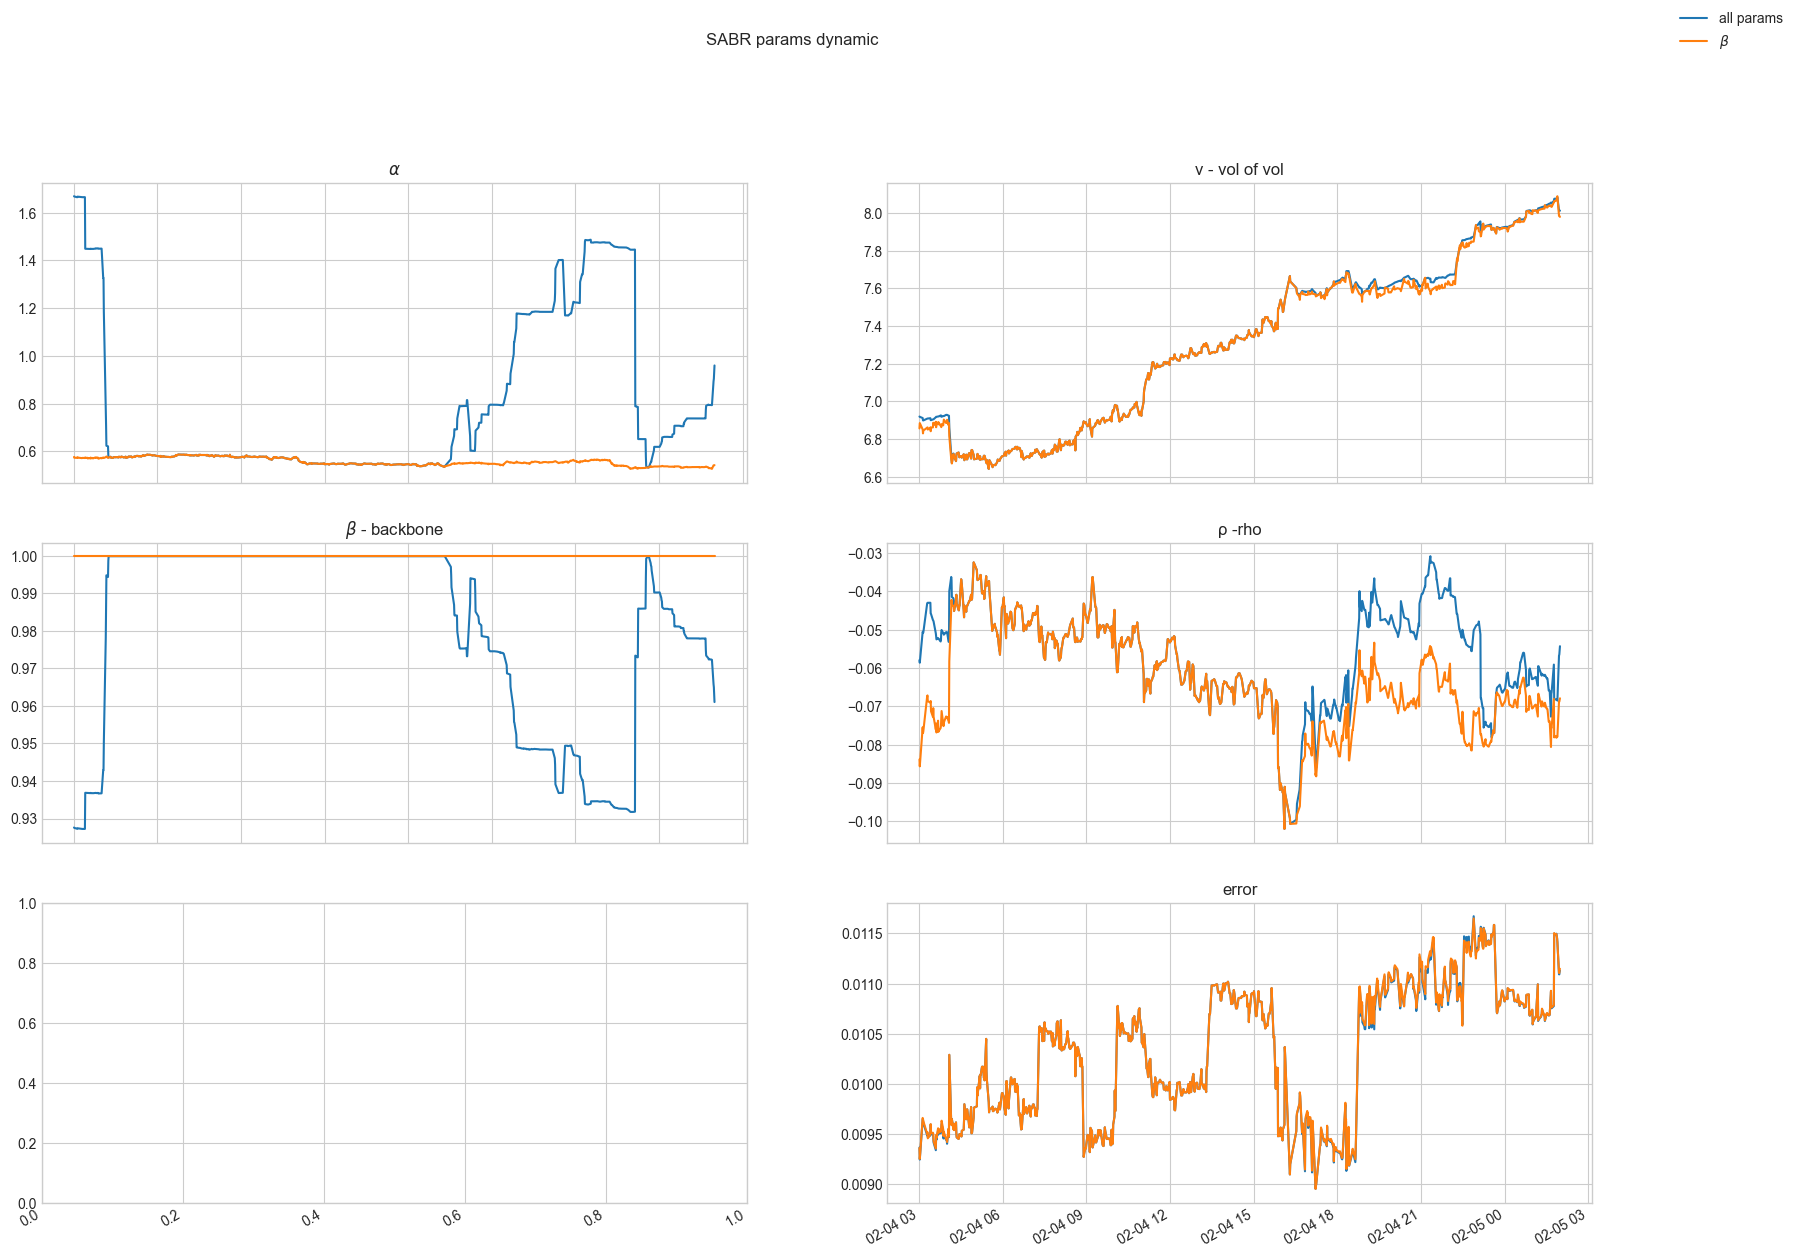

In [157]:
fig, axs =  plt.subplots(nrows=3, ncols=2, figsize=(20, 15))

axs[0, 0].plot(timestamps_hm, params_all[0], label = "all params")
axs[0, 1].plot(timestamps_hm, params_all[1])
axs[1, 0].plot(timestamps_hm, params_all[2])
axs[1, 1].plot(timestamps_hm, params_all[3])
axs[2, 1].plot(timestamps_hm, errors_all)

axs[0, 0].plot(timestamps_hm, params_beta[0], label = r"$\beta$")
axs[0, 1].plot(timestamps_hm, params_beta[1])
axs[1, 0].plot(timestamps_hm, params_beta[2])
axs[1, 1].plot(timestamps_hm, params_beta[3])
axs[2, 1].plot(timestamps_hm, errors_beta)


axs[0, 0].set_title(r"$\alpha$")
axs[0, 1].set_title(r"v - vol of vol")
axs[1, 0].set_title(r"$\beta$ - backbone")
axs[1, 1].set_title("ρ -rho")
axs[2, 1].set_title("error")



# for i in range(3):
#     for j in range(2):
#         for exp in expirarions:
#             axs[i, j].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
#             axs[i, j].axvline(x=exp, color = "black", linestyle  = "--")
#             if i == j == 0:
#                 axs[i, j].axvline(x=exp, color = "black", linestyle  = "--", label = exp)
#                 pass


plt.figlegend() 
fig.suptitle("SABR params dynamic")
plt.gcf().autofmt_xdate()
plt.show()

# Vol smile

In [37]:
df_only_exp = df[df["expiration"] == df.sample(1).expiration.iloc[0]].copy()
stamp = df_only_exp.sample(1).iloc[0].timestamp
print(stamp)

1670931812011000


In [119]:
needed_stamp = 1670931812011000
alpha = np.float64(1.0)  # 
v = np.float64(1.3)  # 
beta = np.float64(0.5)  # 
rho = np.float64(-0.1)  # 

start_params = np.array([alpha, v, beta, rho])

pars_all, err_all, C_all = calibrate_sabr(df = df_only_exp, start_params = start_params, timestamp = needed_stamp,
                                calibration_type= "all")

pars_beta, err_beta, C_beta = calibrate_sabr(df = df_only_exp, start_params = start_params, timestamp = needed_stamp,
                                calibration_type= "beta")

def round_params(params, n_signs = 3):
    return [round(x, n_signs) for x in params]
    

print("All:")
print(round_params(pars_all))
print(err_all)
print("   ")

print("Beta:")
print(round_params(pars_beta))
print(err_beta)


All:
[9.435, 9.588, 0.838, -0.124]
0.00802667564061977
   
Beta:
[9.522, 9.59, 0.838, -0.123]
0.007986982442256796


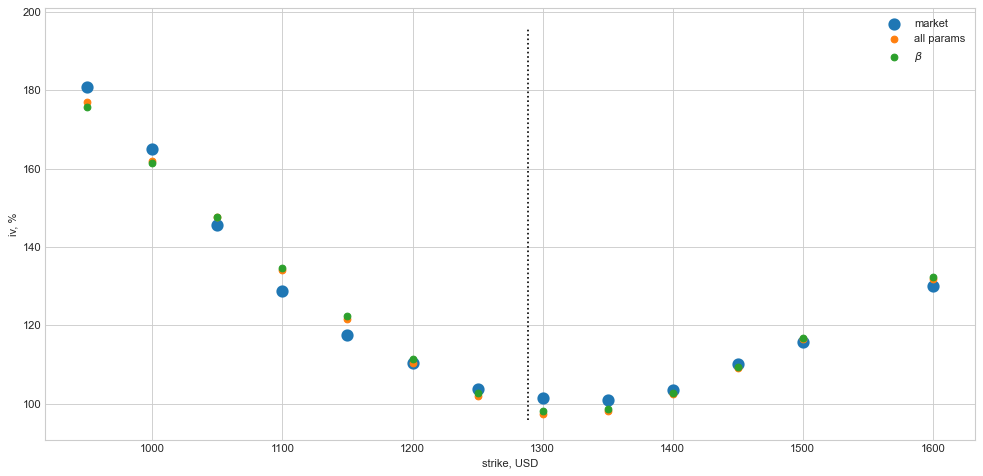

In [110]:
figure(figsize=(15, 7), dpi=80)


plt.scatter(C_all["strike_price"], C_all["iv"], label = "market", linewidths = 5)

# bid,ask iv
# plt.plot(C_sing_exp_all["strike_price"], C_sing_exp_all["ask_iv"], '--', label = "ask_iv", color = "black")
# plt.plot(C_sing_exp_all["strike_price"], C_sing_exp_all["bid_iv"], '--', label = "bid_iv", color = "yellow")

plt.scatter(C_all["strike_price"], C_all["calibrated_iv"], label = "all params")
plt.scatter(C_beta["strike_price"], C_beta["calibrated_iv"], label = r"$\beta$")


plt.vlines([C_all.underlying_price.mean()], C_all.iv.min()-5, 
           C_all.iv.max() + 15, color = "black", linestyles = "dotted")

plt.xlabel("strike, USD")
plt.ylabel("iv, %")
plt.legend()
plt.show()